In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from collections import Counter


path = '/content/default_train_set.csv'

df = pd.read_csv(path)

df_test = pd.read_csv('/content/Default_Test_Set.csv')

df_economic = pd.read_csv('/content/economic_indicators.csv')

In [2]:
X = df.drop(columns=['target'])
y = df['target']

# Divisão
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [3]:
X_train['disbursement_date'] = pd.to_datetime(X_train['disbursement_date'])
X_train['due_date'] = pd.to_datetime(X_train['due_date'])
X_test['disbursement_date'] = pd.to_datetime(X_test['disbursement_date'])
X_test['due_date'] = pd.to_datetime(X_test['due_date'])

df_test['disbursement_date'] = pd.to_datetime(df_test['disbursement_date'])
df_test['due_date'] = pd.to_datetime(df_test['due_date'])

df_test['disbursement_date'] = df_test['disbursement_date'].apply(lambda date: date.toordinal())
df_test['due_date'] = df_test['due_date'].apply(lambda date: date.toordinal())

X_train['disbursement_date'] = X_train['disbursement_date'].apply(lambda date: date.toordinal())
X_train['due_date'] = X_train['due_date'].apply(lambda date: date.toordinal())
X_test['disbursement_date'] = X_test['disbursement_date'].apply(lambda date: date.toordinal())
X_test['due_date'] = X_test['due_date'].apply(lambda date: date.toordinal())

In [4]:
def feature_engineering(data):
    data['Repayment_Percentage'] = data['Total_Amount_to_Repay'] / data['Total_Amount']
    data['Loan_Duration_to_Amount_Ratio'] = data['duration'] / data['Total_Amount']
    data['Profit_Margin'] = data['Total_Amount_to_Repay'] - data['Total_Amount']
    data['Adjusted_Profit_Margin'] = data['Profit_Margin'] / data['duration']
    data['Lender_Contribution_Ratio'] = data['Amount_Funded_By_Lender'] / data['Total_Amount']

    # Conversões de datas
    data['disbursement_date'] = pd.to_datetime(data['disbursement_date'])
    data['due_date'] = pd.to_datetime(data['due_date'])
    data['Days_to_Due'] = (data['due_date'] - data['disbursement_date']).dt.days

    return data

# Aplica separadamente para os dois conjuntos
X_train = feature_engineering(X_train)
X_test = feature_engineering(X_test)

df_test = feature_engineering(df_test)


In [5]:
X_train.drop(columns=['ID','country_id', 'customer_id','tbl_loan_id','lender_id',
                          'New_versus_Repeat'], inplace=True)

X_test.drop(columns=['ID','country_id', 'customer_id','tbl_loan_id','lender_id',
                          'New_versus_Repeat'], inplace=True)

In [6]:
df_test.drop(columns=['country_id', 'customer_id','tbl_loan_id','lender_id',
                          'New_versus_Repeat'], inplace=True)

In [7]:
def categorize_lender_portion(portion):
    if portion > 0.5:
        return 5
    elif portion == 0.5:
        return 4
    elif portion < 0.5 and portion >= 0.3:
        return 3
    elif portion < 0.3 and portion >= 0.2:
        return 2
    elif portion < 0.2 and portion > 0.0:
        return 1
    elif portion == 0.0:
        return 0

X_train['Lender_portion_category'] = X_train['Lender_portion_Funded'].apply(categorize_lender_portion)
X_test['Lender_portion_category'] = X_test['Lender_portion_Funded'].apply(categorize_lender_portion)
df_test['Lender_portion_category'] = df_test['Lender_portion_Funded'].apply(categorize_lender_portion)

# 2. Categorizar Repayment_Percentage
X_train['Repayment_Percentage'] = X_train['Total_Amount_to_Repay'] / X_train['Total_Amount']
X_test['Repayment_Percentage'] = X_test['Total_Amount_to_Repay'] / X_test['Total_Amount']
df_test['Repayment_Percentage'] = df_test['Total_Amount_to_Repay'] / df_test['Total_Amount']

def categorize_repayment_percentage(percentage):
    if percentage > 1.5:
        return 3
    elif percentage > 1.2:
        return 2
    elif percentage > 1.0:
        return 1
    else:
        return 0

X_train['Repayment_Category'] = X_train['Repayment_Percentage'].apply(categorize_repayment_percentage)
X_test['Repayment_Category'] = X_test['Repayment_Percentage'].apply(categorize_repayment_percentage)
df_test['Repayment_Category'] = df_test['Repayment_Percentage'].apply(categorize_repayment_percentage)

X_train = pd.get_dummies(X_train, columns=['Lender_portion_category', 'Repayment_Category'], prefix=['LenderCat', 'RepayCat'])
X_test = pd.get_dummies(X_test, columns=['Lender_portion_category', 'Repayment_Category'], prefix=['LenderCat', 'RepayCat'])
df_test = pd.get_dummies(df_test, columns=['Lender_portion_category', 'Repayment_Category'], prefix=['LenderCat', 'RepayCat'])

X_train, X_test = X_train.align(X_test, join='outer', axis=1, fill_value=0)

In [8]:
from sklearn.utils import resample

# Função para subsamplear
def balanced_subsample(X, y):

    # Concatenar X_train e y_train para processar juntos
    data = pd.concat([X, y], axis=1)

    # Identificar as classes no y_train
    min_class = y.value_counts().min()  # Pega o menor tamanho das classes

    # Subsamplear cada classe para ter o mesmo tamanho
    sampled = pd.concat([
        resample(data[data[y.name] == label],  # Subsamplear para cada classe
                 replace=False,               # Não queremos duplicar dados
                 n_samples=min_class,         # Número de amostras para igualar as classes
                 random_state=42)             # Controlar a aleatoriedade
        for label in y.unique()
    ])

    X_balanced = sampled.drop(columns=y.name)
    y_balanced = sampled[y.name]
    return X_balanced, y_balanced

X_train_balanced, y_train_balanced = balanced_subsample(X_train, y_train)

# Verificar os tamanhos balanceados
print(f"Tamanhos após o subsampleamento:\n{y_train_balanced.value_counts()}")


Tamanhos após o subsampleamento:
target
0    1006
1    1006
Name: count, dtype: int64


In [9]:
num_var = X_train.select_dtypes(include=np.number).columns
num_var_test = X_test.select_dtypes(include=np.number).columns
num_var_df_test = df_test.select_dtypes(include=np.number).columns

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train[num_var])

X_test_scaled = scaler.transform(X_test[num_var_test])

df_test_scaled = scaler.transform(df_test[num_var_test])


In [21]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score
import numpy as np

# Definir os hiperparâmetros a testar
param_dist = {
    'n_estimators': np.arange(50, 300, 50),
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Inicializando o modelo de Random Forest
rf = RandomForestClassifier(random_state=42)

# Realizando o Random Search com 5-fold cross-validation
random_search = RandomizedSearchCV(
    rf, param_distributions=param_dist, n_iter=8, cv=5, verbose=1, random_state=42, n_jobs=-1
)

# Treinando o modelo
random_search.fit(X_train_scaled, y_train)

# Melhores parâmetros encontrados
print(f"Melhores parâmetros: {random_search.best_params_}")

# Avaliação no conjunto de teste
y_pred = random_search.predict(X_test_scaled)

# Mostrar o F1 Score
print(f"F1 Score no conjunto de teste: {f1_score(y_test, y_pred)}")

# Imprimir classificação detalhada
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
5 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_pa

Melhores parâmetros: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
F1 Score no conjunto de teste: 0.8549019607843137
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13479
           1       0.84      0.87      0.85       252

    accuracy                           0.99     13731
   macro avg       0.92      0.93      0.93     13731
weighted avg       0.99      0.99      0.99     13731



In [22]:
rf_best_params = {
    'n_estimators': 50,
    'min_samples_split': 5,
    'min_samples_leaf': 1,
    'max_features': 'sqrt',
    'max_depth': None,
    'bootstrap': False
}

# Inicializando o modelo Random Forest com os melhores parâmetros
rf_best = RandomForestClassifier(**rf_best_params, random_state=42)

# Treinando o modelo nos dados de treinamento
rf_best.fit(X_train_scaled, y_train)

# Fazendo predições no conjunto de teste
y_pred_3 = rf_best.predict(X_test_scaled)

# Avaliando o modelo com F1 Score
f1 = f1_score(y_test, y_pred_3)
print(f"F1 Score no conjunto de teste: {f1}")

# Imprimir classificação detalhada
print(classification_report(y_test, y_pred_3))

F1 Score no conjunto de teste: 0.8549019607843137
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13479
           1       0.84      0.87      0.85       252

    accuracy                           0.99     13731
   macro avg       0.92      0.93      0.93     13731
weighted avg       0.99      0.99      0.99     13731



In [12]:
from sklearn.metrics import classification_report, accuracy_score

rf.fit(X_train_scaled, y_train)

y_pred = rf.predict(X_test_scaled)

# 3. Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))





Accuracy: 0.9935911441264292
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13479
           1       0.86      0.78      0.82       252

    accuracy                           0.99     13731
   macro avg       0.93      0.89      0.91     13731
weighted avg       0.99      0.99      0.99     13731



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/10
1374/1374 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9444 - loss: 0.2091 - val_accuracy: 0.9881 - val_loss: 0.0452
Epoch 2/10
1374/1374 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9885 - loss: 0.0382 - val_accuracy: 0.9884 - val_loss: 0.0381
Epoch 3/10
1374/1374 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9889 - loss: 0.0332 - val_accuracy: 0.9888 - val_loss: 0.0346
Epoch 4/10
1374/1374 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9891 - loss: 0.0307 - val_accuracy: 0.9900 - val_loss: 0.0312
Epoch 5/10
1374/1374 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9887 - loss: 0.0307 - val_accuracy: 0.9891 - val_loss: 0.0295
Epoch 6/10
1374/1374 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9897 - loss: 0.0275 - val_accuracy: 0.9900 - val_loss: 0.0300
Epoch 7/10
1374/1374 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9895 - loss: 0.0274 - val_accuracy: 0.9901 - val_loss: 0.0273
Epoch 8/10
1374/1374 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9906 - loss: 0.0259 - 

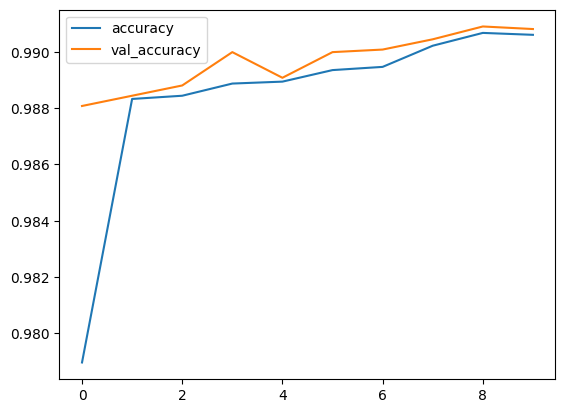

In [19]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

model = tf.keras.Sequential()

model.add(tf.keras.layers.InputLayer(input_shape=(X_train_scaled.shape[1],)))

model.add(tf.keras.layers.Dense(64, activation='relu'))

model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.2)

y_pred_2 = model.predict(X_test_scaled)
y_pred_2 = (y_pred > 0.5).astype(int)

print(classification_report(y_test, y_pred_2))

# Você também pode plotar o histórico de aprendizado, caso queira ver como as métricas evoluem:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [23]:
X_test_comp = df_test_scaled
predictions = rf_best.predict(X_test_comp)

In [27]:
submission_1 = pd.DataFrame({
    'ID': df_test['ID'],
    'target': predictions
})

submission_1.to_csv('submission_1.csv', index=False)

In [15]:
correlation_matrix = df[num_var].corr()

# Create a heatmap for visualization
plt.figure(figsize=(12, 10))  # Adjust the figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of df_balanced")
plt.show()

NameError: name 'df_balanced' is not defined

In [ ]:
# Definição das variáveis contínuas e categóricas
var_continuous = ['Total_Amount', 'Total_Amount_to_Repay', 'Amount_Funded_By_Lender',
                  'Lender_portion_Funded', 'duration', 'Lender_portion_to_be_repaid',
                                    'Repayment_Percentage', 'Loan_Duration_to_Amount_Ratio',
'Profit_Margin', 'Days_to_Due', 'Lender_Contribution_Ratio',
                  'Adjusted_Profit_Margin']

cat_var = ['Repayment_Category', 'Lender_portion_category', 'loan_type']

var_log = ['Total_Amount', 'Total_Amount_to_Repay', 'Amount_Funded_By_Lender',
           'Lender_portion_to_be_repaid']

var_final_continuous = var_log + var_continuous
